In [21]:
import numpy as np
import matplotlib.pyplot as plt
import lsst.afw.display as afwDisplay
display = afwDisplay.getDisplay()
import scipy
from scipy.ndimage import shift as scipy_shift
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize
# import scipy.ndimage.shift as scipy_shift

In [39]:
def plot_image(image, title, fig=None, zscale=True, norm=None, show_colorbar=True):
    fig = plt.figure(figsize=(8, 6))
    plt.suptitle(title)
    im = plt.imshow(image, norm=norm, cmap='gray')
    if show_colorbar:
        cbar_width = 0.01
        cbar_height = 0.5
        cbar_ax = fig.add_axes([0.9 - cbar_width, 0.5 - cbar_height/2, cbar_width, cbar_height])
        fig.colorbar(im, cax=cbar_ax)

Part 1:
In a Jupyter python notebook, create a 256x256 pixel numpy array with a single pixel with value 1 roughly in the center.

In [12]:
img_base = np.zeros((256,256))
x0 = 150
y0 = 110
img_base[y0, x0] = 1

Question 1a: Shifting images in image space

Use scipy.ndimage.shift to shift a copy of the image by a fraction of a pixel (say 0.34 in x and 0.2 in y). FFT the shifted image and the original, and divide the FFT of the shifted image by the FFT of the original. Make two images of the result: one of the amplitude, the other of the phase.

In [29]:
scipy_shift?

In [98]:
dx = .2
dy = .34

In [99]:
img_shift = scipy_shift(img_base, [dy, dx], prefilter=True, order=1)

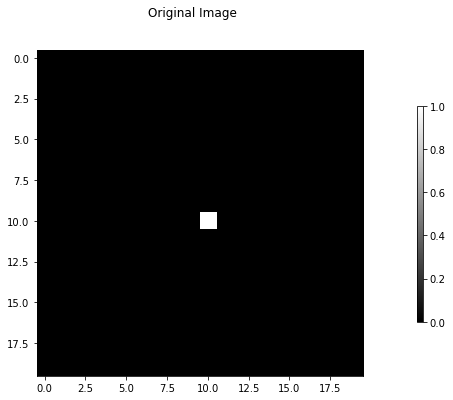

In [100]:
plot_image(img_base[y0-10:y0+10,x0-10:x0+10],"Original Image")

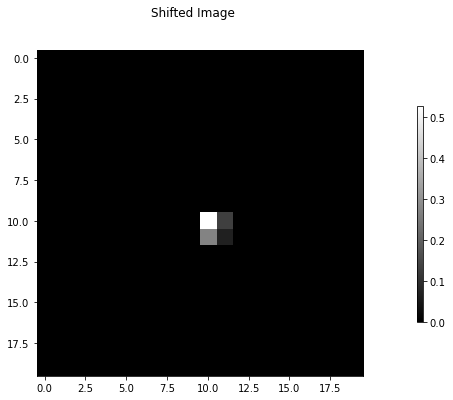

In [101]:
plot_image(img_shift[y0-10:y0+10,x0-10:x0+10],"Shifted Image")

Fourier space

In [102]:
img0_fft = np.fft.fftshift(np.fft.ifft2(img_base))

In [103]:
img1_fft = np.fft.fftshift(np.fft.ifft2(img_shift))

In [104]:
fft_ratio = img1_fft/img0_fft

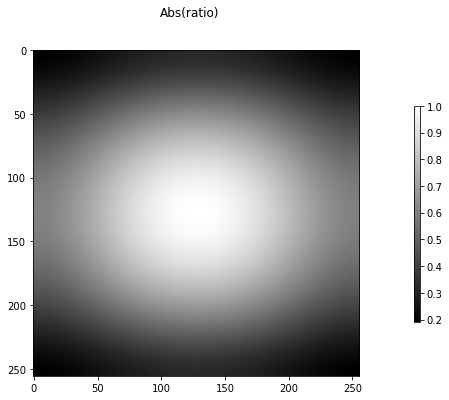

In [105]:
plot_image(np.abs(fft_ratio),"Abs(ratio)")

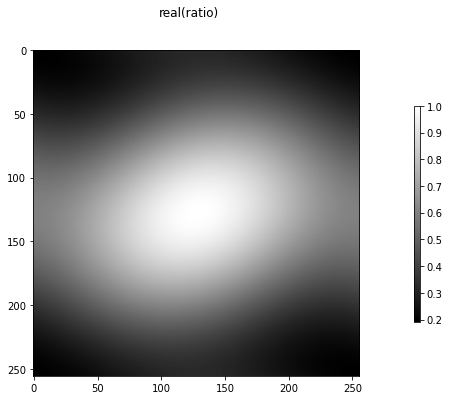

In [106]:
plot_image(np.real(fft_ratio),"real(ratio)")

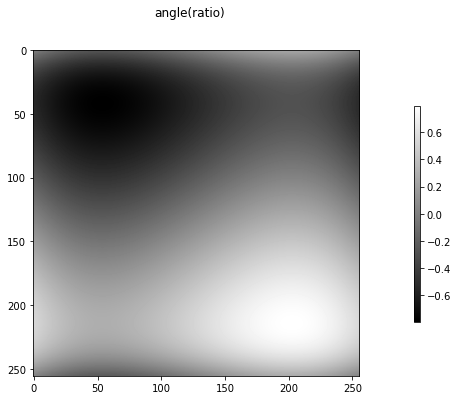

In [107]:
plot_image(np.angle(fft_ratio),"angle(ratio)")

Now calculate the shift in Fourier space

In [181]:
def calculate_phase_shift(dimension, elements, dx, dy):
    icomp = complex(0,1)
    xv, yv = np.meshgrid(np.arange(dimension), np.arange(elements))
    phase = np.exp(2*icomp*np.pi*((xv - dimension/2)*dx/dimension + (yv - elements/2)*dy/elements))
    return phase


In [182]:
phase = calculate_phase_shift(256,256, dx, dy)

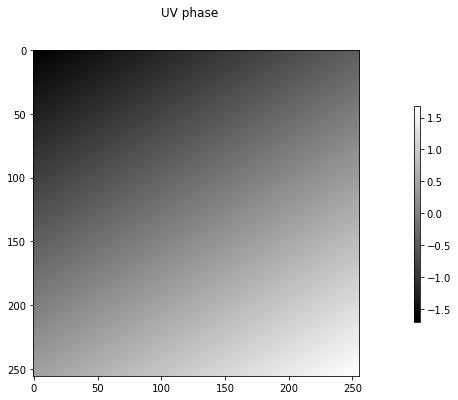

In [183]:
plot_image(np.angle(phase),"UV phase")

In [184]:
img0_fft_uv_shift = img0_fft*phase

In [185]:
img_uv_shifted = np.real(np.fft.fft2(np.fft.fftshift(img0_fft_uv_shift)))

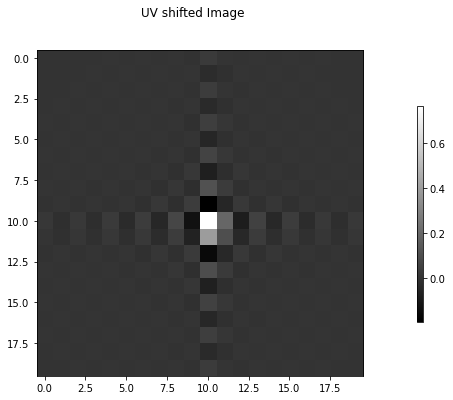

In [186]:
plot_image(img_uv_shifted[y0-10:y0+10,x0-10:x0+10],"UV shifted Image")

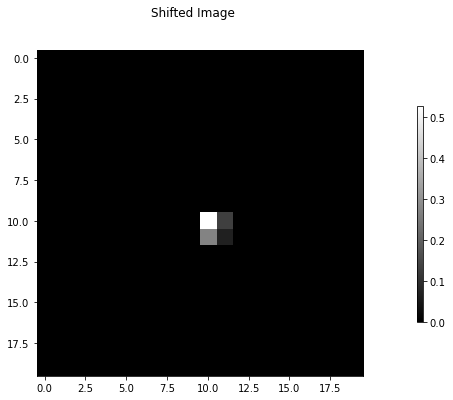

In [188]:
plot_image(img_shift[y0-10:y0+10,x0-10:x0+10],"Shifted Image")

## Question 2a: Aliasing

Create a 256x256 pixel numpy array containing a 2D gaussian at the center, with a width roughly 1/10 the size of the full image (it should look compact). Take the FFT of a copy, and make an image of the real part of the result. If it oscillates, you need to apply an FFT shift first. Use this image as a reference to create the analytic Fourier transform of your gaussian directly in Fourier space. FFT the new Fourier analytic gaussian back to image space, and subtract the result from the original. Make an image of the residual.

In [340]:
def gaussian2d (dimension, elements, xcenter = 128, ycenter = 128, sigmax = 25.6, sigmay = 25.6, use_fourier=False):
    xv, yv = np.meshgrid(np.arange(dimension), np.arange(elements))
    diffx = xv - xcenter
    diffy = yv - ycenter

    a_x = 1/(2*sigmax**2)
    a_y = 1/(2*sigmay**2)
    k_x = 2*np.pi
    k_y = 2*np.pi
    if use_fourier:
        pre_x = k_x*np.pi**2/(a_x*2*np.pi*dimension**2)
        pre_y = k_y*np.pi**2/(a_y*2*np.pi*dimension**2)
    else:
        pre_x = a_x
        pre_y = a_y
    print(pre_x)
    gaussian = np.exp(-((pre_x*diffx**2)+(pre_y*diffy**2)))
    return gaussian


In [341]:
img_gaussian0 = gaussian2d(256,256)

0.0007629394531249999


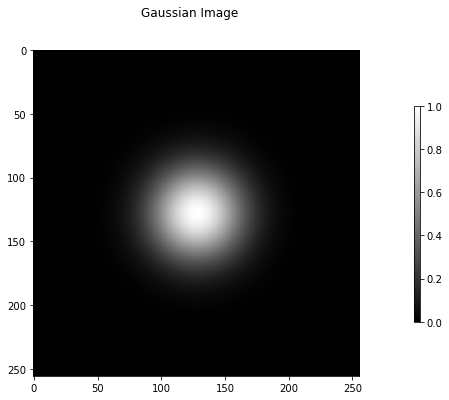

In [342]:
plot_image(img_gaussian0,"Gaussian Image")

In [343]:
img_gaussian0_fft = np.sqrt(256)*np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(img_gaussian0)))

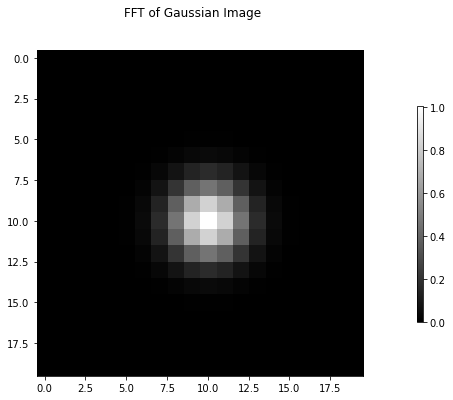

In [344]:
plot_image(np.real(img_gaussian0_fft[128-10:128+10,128-10:128+10]),"FFT of Gaussian Image")

In [345]:
img_gaussian1_fft = gaussian2d(256,256, use_fourier=True)

0.19739208802178718


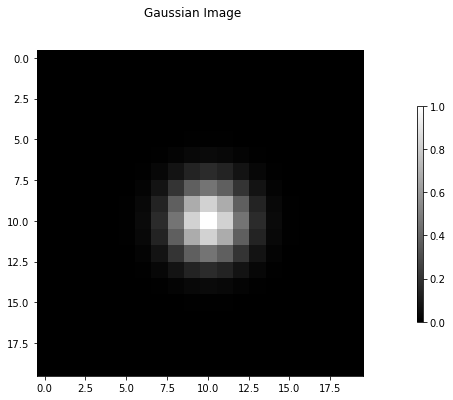

In [346]:
plot_image(img_gaussian1_fft[128-10:128+10,128-10:128+10],"Gaussian Image")